In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from matplotlib.animation import FuncAnimation
from numba import jit
from time import time
from numpy.random import random
from scipy.fft import fft2, fft, fftfreq
import os

In [2]:
class Molecular_Dynamics:
    def __init__(self, N, L, dt, t_max, x, v, m, delta=1):
        self.L = L
        self.t_max = t_max
        self.dt = dt
        self.m = m
        self.delta = delta
        self.x = x
        self.v = v
        self.x_data = [x]
        self.v_data = [v]
        self.t = [0]
        self.pair_idx = tuple((i, i+1) for i in range(N-1))   # pair index 
        self.single_idx = (0, N-1)
        self.number_of_events = 0
        
        
    def simulation(self): 
        while self.t[-1] < t_max:
            t_event, event_idx = self.compute_next_event()
            for i in range(int(self.t[-1]/self.dt)+1, int((self.t[-1]+t_event)/dt)+1):
                self.x = np.copy(self.x + self.v * self.dt)
                self.x_data.append(self.x)
                self.v_data.append(self.v)
                self.t.append(self.t[-1] + self.dt)
                if self.t[-1] >= self.t_max: break
            self.update_v(event_idx)
            self.number_of_events += 1
            
    def get_data(self, p):
        x_data = np.array(self.x_data)[:-1]  
        v_data = np.array(self.v_data)[:-1]  
        E_data = 0.5 * self.m * v_data**2
        t = np.array(self.t)[:-1]
        if p: print("number of collisions", self.number_of_events)
        return x_data, v_data, E_data, t
        
    def pair_time(self, xi, xj, vi, vj):
        dv = vi - vj
        if dv < 0: return np.inf
        return (xj - xi - self.delta)/dv
    
    def pair_collision(self, vi, vj, mi, mj):
        vi_f = vi*(mi-mj)/(mi+mj) + vj*2*mj/(mi+mj)
        vj_f = vi*2*mi/(mi+mj) - vj*(mi-mj)/(mi+mj)
        return vi_f, vj_f
    
    def wall_time(self, x0, xN, v0, vN):
        t0 = (x0 - self.delta/2)/abs(v0) if v0 < 0 else np.inf
        tn = (L - xN - self.delta/2)/vN if vN > 0 else np.inf
        return [t0, tn]
    
    def wall_collision(self, vi):
        return -vi
    
    def compute_next_event(self):
        x, v = self.x, self.v
        pair_times = [self.pair_time(x[i], x[j], v[i], v[j]) for i, j in self.pair_idx]
        wall_times = self.wall_time(x[0], x[-1], v[0], v[-1])
        times = np.array(wall_times + pair_times)
        arg = np.argmin(times)
        t_event = times[arg]
        event_idx = self.single_idx[arg] if arg < 2 else self.pair_idx[arg-2]
        return t_event, event_idx
    
    def update_v(self, event_idx):
        v = self.v.copy()
        if type(event_idx) == tuple:
            i, j = event_idx # i and the i+1 element pair(i,j)
            v[i], v[j] = self.pair_collision(v[i], v[j], m[i], m[j])
        else:
            i = event_idx
            v[i] = self.wall_collision(v[i])
        self.v = v

In [3]:
class Monte_Carlo:
    def __init__(self, L, delta = 1, T=1):
        self.L = L # length of simulation box
        self.delta = delta # size of the particles
        self.T = T # temperature 
        
    def sample_configuration(self):
        x = self.sample_positions()
        N = len(x)
        m = np.ones(N)
        v = self.sample_velocities(N, m)
        print(x)
        print(N)
        return x, v, m
   
    def sample_velocities(self, N, m):
        k_b = 1.38064
        sigma = np.sqrt((k_b * self.T)/m)
        v = np.random.normal(loc = 0, scale = sigma, size=N)
        return v
    
    def sample_positions(self):
        x_positions = []
        next_position = 0.5 + np.random.poisson(2)
        while next_position < self.L - 0.5:
            x_positions.append(next_position)
            next_position = x_positions[-1] + 1 + np.random.poisson(1)
        return x_positions

In [4]:
def observables(nbins, x_data, v_data, E_data, m, N):
    x_grid = np.linspace(0, L, nbins)
    dx = x_grid[1]
    
    enumerate(x_grid)
    
    q0 = np.zeros((len(t),len(x_grid)))
    q1 = np.zeros((len(t),len(x_grid)))
    q2 = np.zeros((len(t),len(x_grid)))
    
    j0 = np.zeros((len(t),len(x_grid)))
    j1 = np.zeros((len(t),len(x_grid)))
    j2 = np.zeros((len(t),len(x_grid)))
    
    for ((x_, v_), (E_, m_)) in zip(zip(x_data.T, v_data.T), zip(E_data.T, m)):
        for i, a in enumerate(x_grid):
            idx = np.logical_and(a < x_, x_ < a + dx)
            q0[:,i] += idx.astype(int)
            q1[:,i] += v_*m_*idx.astype(int)
            q2[:,i] += E_*idx.astype(int)
            j0[:,i] += v_*idx.astype(int)
            j1[:,i] += v_*m_*v_*idx.astype(int)
            j2[:,i] += E_*v_*idx.astype(int)
    
            
    q0 = q0 / N
    q1 = q1 / N
    q2 = q2 / N
    
    j0 = j0 / N
    j1 = j1 / N
    j2 = j2 / N
    
    return x_grid, q0, q1, q2, j0, j1, j2

In [10]:
L = 1000
t_max = 10
dt = 0.001

MC = Monte_Carlo(L, T = 293.15)

n_MC = 2000 #Number of monte carlo simulations must change this to 1000

for i in range(n_MC):
    x, v, m = MC.sample_configuration()

    N = len(x)

    MD = Molecular_Dynamics(N, L, dt, t_max, x, v, m)
    MD.simulation()

    x_data, v_data, E_data, t = MD.get_data(p = True)

    nbins = 100

    x_grid, q0, q1, q2, j0, j1, j2 = observables(nbins, x_data, v_data, E_data, m, N)

    mid = q0.shape[1]//2 #Half of the box (position we want to correlate)#
    
    maxtime = 10000
 
    if i == 0:
        term11 = q0[0:maxtime, :] * q0[0,mid]
        term21 = q0[0:maxtime,:]
        term31 = q0[0,mid]
        
        term12 = q1[0:maxtime, :] * q1[0,mid]
        term22 = q1[0:maxtime,:]
        term32 = q1[0,mid]
        
        term13 = q2[0:maxtime, :] * q2[0,mid]
        term23 = q2[0:maxtime,:]
        term33 = q2[0,mid]
        
        term14 = j0[0:maxtime, :] * j0[0,mid]
        term24 = j0[0:maxtime,:]
        term34 = j0[0,mid]
        
        term15 = j1[0:maxtime, :] * j1[0,mid]
        term25 = j1[0:maxtime,:]
        term35 = j1[0,mid]
        
        term16 = j2[0:maxtime, :] * j2[0,mid]
        term26 = j2[0:maxtime,:]
        term36 = j2[0,mid]
        print(i)

    else:
        term11 += q0[0:maxtime, :] * q0[0,mid]
        term21 += q0[0:maxtime, :]
        term31 += q0[0,mid]
        
        term12 += q1[0:maxtime, :] * q1[0,mid]
        term22 += q1[0:maxtime, :]
        term32 += q1[0,mid]
        
        term13 += q2[0:maxtime, :] * q2[0,mid]
        term23 += q2[0:maxtime, :]
        term33 += q2[0,mid]
        
        term14 += j0[0:maxtime, :] * j0[0,mid]
        term24 += j0[0:maxtime, :]
        term34 += j0[0,mid]
        
        term15 += j1[0:maxtime, :] * j1[0,mid]
        term25 += j1[0:maxtime, :]
        term35 += j1[0,mid]
        
        term16 += j2[0:maxtime, :] * j2[0,mid]
        term26 += j2[0:maxtime, :]
        term36 += j2[0,mid]
        print(i)

C0 = (term11 / n_MC) - ((term31 / n_MC)*(term21 / n_MC))
C1 = (term12 / n_MC) - ((term32 / n_MC)*(term22 / n_MC))
C2 = (term13 / n_MC) - ((term33 / n_MC)*(term23 / n_MC))
C3 = (term14 / n_MC) - ((term34 / n_MC)*(term24 / n_MC))
C4 = (term15 / n_MC) - ((term35 / n_MC)*(term25 / n_MC))
C5 = (term16 / n_MC) - ((term36 / n_MC)*(term26 / n_MC))

[0.5, 2.5, 3.5, 5.5, 7.5, 8.5, 11.5, 12.5, 14.5, 18.5, 21.5, 23.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5, 34.5, 36.5, 37.5, 39.5, 41.5, 43.5, 46.5, 48.5, 49.5, 52.5, 53.5, 56.5, 57.5, 59.5, 61.5, 62.5, 64.5, 66.5, 68.5, 70.5, 72.5, 73.5, 74.5, 77.5, 78.5, 80.5, 84.5, 85.5, 87.5, 89.5, 91.5, 93.5, 97.5, 101.5, 103.5, 104.5, 105.5, 108.5, 111.5, 113.5, 114.5, 115.5, 117.5, 119.5, 120.5, 122.5, 124.5, 130.5, 131.5, 132.5, 134.5, 135.5, 139.5, 140.5, 142.5, 145.5, 147.5, 148.5, 149.5, 152.5, 153.5, 154.5, 156.5, 157.5, 160.5, 161.5, 164.5, 166.5, 167.5, 168.5, 171.5, 173.5, 174.5, 178.5, 180.5, 181.5, 182.5, 186.5, 187.5, 189.5, 190.5, 191.5, 192.5, 194.5, 195.5, 197.5, 199.5, 200.5, 201.5, 202.5, 204.5, 207.5, 208.5, 212.5, 213.5, 216.5, 221.5, 222.5, 226.5, 228.5, 229.5, 232.5, 233.5, 235.5, 236.5, 237.5, 238.5, 242.5, 245.5, 247.5, 248.5, 249.5, 251.5, 253.5, 255.5, 257.5, 260.5, 263.5, 266.5, 268.5, 269.5, 271.5, 273.5, 277.5, 279.5, 281.5, 283.5, 284.5, 286.5, 287.5, 288.5, 2

number of collisions 27537
4
[4.5, 5.5, 6.5, 7.5, 8.5, 11.5, 14.5, 16.5, 19.5, 24.5, 25.5, 26.5, 28.5, 30.5, 33.5, 35.5, 38.5, 40.5, 41.5, 42.5, 45.5, 46.5, 47.5, 48.5, 50.5, 52.5, 53.5, 56.5, 59.5, 60.5, 61.5, 63.5, 65.5, 67.5, 70.5, 72.5, 74.5, 76.5, 77.5, 79.5, 81.5, 83.5, 84.5, 85.5, 86.5, 88.5, 90.5, 92.5, 95.5, 98.5, 99.5, 100.5, 101.5, 104.5, 106.5, 107.5, 108.5, 109.5, 112.5, 113.5, 117.5, 119.5, 120.5, 124.5, 127.5, 129.5, 130.5, 131.5, 134.5, 137.5, 139.5, 140.5, 141.5, 142.5, 144.5, 146.5, 148.5, 152.5, 153.5, 154.5, 155.5, 157.5, 158.5, 160.5, 161.5, 162.5, 164.5, 165.5, 166.5, 167.5, 168.5, 170.5, 172.5, 177.5, 178.5, 180.5, 184.5, 189.5, 191.5, 192.5, 195.5, 198.5, 200.5, 202.5, 203.5, 206.5, 207.5, 208.5, 211.5, 213.5, 215.5, 216.5, 219.5, 222.5, 226.5, 227.5, 230.5, 232.5, 234.5, 235.5, 238.5, 241.5, 243.5, 246.5, 251.5, 252.5, 254.5, 257.5, 258.5, 261.5, 262.5, 264.5, 265.5, 267.5, 268.5, 269.5, 270.5, 272.5, 274.5, 276.5, 277.5, 278.5, 281.5, 284.5, 285.5, 286.5, 287.

number of collisions 29086
9
[4.5, 6.5, 8.5, 10.5, 13.5, 14.5, 16.5, 18.5, 21.5, 23.5, 24.5, 28.5, 29.5, 30.5, 34.5, 36.5, 40.5, 41.5, 43.5, 44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 54.5, 55.5, 58.5, 60.5, 62.5, 64.5, 65.5, 66.5, 67.5, 68.5, 70.5, 72.5, 74.5, 76.5, 79.5, 81.5, 83.5, 86.5, 88.5, 89.5, 90.5, 91.5, 93.5, 95.5, 97.5, 99.5, 102.5, 104.5, 105.5, 107.5, 111.5, 113.5, 114.5, 115.5, 117.5, 119.5, 120.5, 123.5, 124.5, 126.5, 128.5, 129.5, 131.5, 133.5, 136.5, 137.5, 142.5, 145.5, 147.5, 151.5, 153.5, 156.5, 159.5, 160.5, 161.5, 163.5, 165.5, 168.5, 170.5, 172.5, 173.5, 176.5, 179.5, 180.5, 181.5, 182.5, 183.5, 184.5, 185.5, 188.5, 192.5, 194.5, 197.5, 200.5, 201.5, 203.5, 205.5, 207.5, 209.5, 212.5, 215.5, 219.5, 221.5, 223.5, 225.5, 227.5, 229.5, 230.5, 231.5, 232.5, 233.5, 235.5, 237.5, 238.5, 240.5, 241.5, 242.5, 243.5, 245.5, 247.5, 248.5, 250.5, 251.5, 254.5, 256.5, 257.5, 259.5, 260.5, 261.5, 262.5, 263.5, 265.5, 266.5, 269.5, 270.5, 274.5, 275.5, 277.5, 279.5, 281.5, 285.5, 28

number of collisions 27938
14
[2.5, 4.5, 5.5, 7.5, 8.5, 13.5, 14.5, 15.5, 16.5, 18.5, 23.5, 24.5, 26.5, 31.5, 32.5, 34.5, 36.5, 37.5, 40.5, 43.5, 44.5, 47.5, 49.5, 51.5, 52.5, 55.5, 56.5, 57.5, 59.5, 63.5, 64.5, 65.5, 68.5, 70.5, 73.5, 76.5, 78.5, 79.5, 80.5, 81.5, 82.5, 84.5, 87.5, 89.5, 90.5, 93.5, 95.5, 96.5, 97.5, 101.5, 103.5, 105.5, 106.5, 107.5, 109.5, 113.5, 115.5, 116.5, 117.5, 119.5, 121.5, 124.5, 126.5, 128.5, 130.5, 131.5, 134.5, 135.5, 138.5, 140.5, 141.5, 144.5, 146.5, 149.5, 150.5, 152.5, 154.5, 156.5, 157.5, 160.5, 164.5, 166.5, 167.5, 169.5, 171.5, 172.5, 174.5, 175.5, 177.5, 179.5, 180.5, 183.5, 185.5, 186.5, 188.5, 189.5, 192.5, 194.5, 196.5, 197.5, 199.5, 202.5, 205.5, 207.5, 209.5, 211.5, 213.5, 214.5, 215.5, 216.5, 218.5, 221.5, 223.5, 225.5, 227.5, 230.5, 232.5, 234.5, 237.5, 240.5, 242.5, 245.5, 247.5, 249.5, 253.5, 255.5, 258.5, 260.5, 262.5, 265.5, 267.5, 269.5, 272.5, 276.5, 278.5, 283.5, 285.5, 286.5, 287.5, 288.5, 292.5, 293.5, 296.5, 297.5, 302.5, 304.5, 3

number of collisions 26422
19
[2.5, 4.5, 5.5, 7.5, 9.5, 11.5, 14.5, 15.5, 16.5, 17.5, 18.5, 20.5, 22.5, 23.5, 26.5, 28.5, 30.5, 31.5, 35.5, 38.5, 41.5, 43.5, 46.5, 49.5, 51.5, 52.5, 56.5, 57.5, 59.5, 62.5, 63.5, 64.5, 68.5, 70.5, 73.5, 76.5, 79.5, 80.5, 82.5, 85.5, 88.5, 92.5, 93.5, 95.5, 97.5, 99.5, 101.5, 103.5, 105.5, 106.5, 109.5, 110.5, 112.5, 113.5, 114.5, 119.5, 121.5, 122.5, 123.5, 124.5, 125.5, 128.5, 130.5, 132.5, 135.5, 136.5, 138.5, 141.5, 143.5, 144.5, 147.5, 151.5, 153.5, 156.5, 157.5, 158.5, 161.5, 164.5, 166.5, 167.5, 169.5, 170.5, 173.5, 174.5, 175.5, 176.5, 178.5, 183.5, 188.5, 190.5, 193.5, 194.5, 196.5, 198.5, 199.5, 203.5, 204.5, 205.5, 206.5, 210.5, 211.5, 212.5, 213.5, 215.5, 217.5, 218.5, 220.5, 222.5, 226.5, 227.5, 231.5, 232.5, 235.5, 237.5, 239.5, 240.5, 241.5, 243.5, 246.5, 248.5, 250.5, 252.5, 254.5, 256.5, 258.5, 263.5, 264.5, 266.5, 267.5, 270.5, 274.5, 275.5, 278.5, 280.5, 283.5, 284.5, 285.5, 286.5, 289.5, 290.5, 293.5, 294.5, 296.5, 298.5, 302.5, 304.5

number of collisions 27392
24
[3.5, 5.5, 8.5, 10.5, 12.5, 13.5, 15.5, 17.5, 18.5, 19.5, 21.5, 22.5, 24.5, 26.5, 29.5, 31.5, 32.5, 34.5, 36.5, 40.5, 42.5, 43.5, 47.5, 49.5, 51.5, 54.5, 55.5, 56.5, 61.5, 63.5, 67.5, 70.5, 71.5, 73.5, 76.5, 79.5, 80.5, 82.5, 83.5, 84.5, 87.5, 88.5, 89.5, 90.5, 94.5, 95.5, 96.5, 97.5, 102.5, 104.5, 106.5, 108.5, 112.5, 114.5, 115.5, 118.5, 119.5, 121.5, 122.5, 124.5, 128.5, 130.5, 132.5, 134.5, 135.5, 136.5, 138.5, 141.5, 142.5, 144.5, 146.5, 147.5, 148.5, 150.5, 151.5, 154.5, 155.5, 157.5, 162.5, 164.5, 166.5, 167.5, 168.5, 172.5, 173.5, 175.5, 177.5, 179.5, 180.5, 181.5, 183.5, 185.5, 186.5, 187.5, 189.5, 190.5, 191.5, 194.5, 196.5, 198.5, 199.5, 201.5, 202.5, 205.5, 207.5, 208.5, 210.5, 212.5, 213.5, 215.5, 216.5, 219.5, 220.5, 224.5, 226.5, 228.5, 231.5, 233.5, 234.5, 237.5, 241.5, 243.5, 244.5, 245.5, 246.5, 249.5, 251.5, 253.5, 255.5, 257.5, 259.5, 261.5, 265.5, 268.5, 272.5, 275.5, 276.5, 277.5, 280.5, 281.5, 284.5, 286.5, 287.5, 289.5, 290.5, 293.5

number of collisions 28209
29
[4.5, 5.5, 6.5, 8.5, 10.5, 12.5, 17.5, 18.5, 20.5, 22.5, 24.5, 26.5, 28.5, 31.5, 33.5, 35.5, 36.5, 39.5, 40.5, 44.5, 46.5, 51.5, 54.5, 55.5, 56.5, 57.5, 60.5, 62.5, 63.5, 66.5, 68.5, 73.5, 75.5, 78.5, 80.5, 83.5, 85.5, 87.5, 89.5, 91.5, 94.5, 97.5, 98.5, 100.5, 102.5, 104.5, 107.5, 108.5, 111.5, 117.5, 121.5, 122.5, 123.5, 125.5, 127.5, 128.5, 130.5, 133.5, 136.5, 139.5, 142.5, 144.5, 145.5, 151.5, 152.5, 153.5, 154.5, 156.5, 157.5, 158.5, 160.5, 161.5, 163.5, 166.5, 167.5, 168.5, 170.5, 172.5, 174.5, 176.5, 178.5, 181.5, 184.5, 187.5, 190.5, 191.5, 194.5, 195.5, 197.5, 198.5, 200.5, 201.5, 204.5, 207.5, 210.5, 213.5, 215.5, 216.5, 217.5, 218.5, 220.5, 222.5, 223.5, 224.5, 225.5, 227.5, 228.5, 230.5, 232.5, 234.5, 236.5, 237.5, 238.5, 241.5, 243.5, 245.5, 247.5, 248.5, 250.5, 253.5, 255.5, 259.5, 261.5, 264.5, 266.5, 267.5, 270.5, 271.5, 272.5, 274.5, 276.5, 278.5, 280.5, 283.5, 285.5, 288.5, 289.5, 291.5, 295.5, 297.5, 301.5, 302.5, 304.5, 307.5, 308.5, 3

number of collisions 31396
34
[2.5, 4.5, 5.5, 8.5, 10.5, 13.5, 15.5, 17.5, 19.5, 21.5, 22.5, 25.5, 26.5, 27.5, 30.5, 31.5, 33.5, 34.5, 36.5, 38.5, 39.5, 41.5, 42.5, 43.5, 46.5, 47.5, 50.5, 53.5, 54.5, 57.5, 59.5, 60.5, 62.5, 64.5, 65.5, 67.5, 70.5, 72.5, 73.5, 74.5, 75.5, 76.5, 78.5, 79.5, 81.5, 84.5, 86.5, 89.5, 91.5, 93.5, 96.5, 98.5, 99.5, 103.5, 104.5, 105.5, 107.5, 108.5, 109.5, 111.5, 114.5, 116.5, 118.5, 120.5, 122.5, 125.5, 127.5, 128.5, 130.5, 131.5, 138.5, 144.5, 145.5, 146.5, 148.5, 151.5, 153.5, 154.5, 155.5, 158.5, 161.5, 163.5, 166.5, 167.5, 169.5, 171.5, 172.5, 175.5, 179.5, 182.5, 183.5, 185.5, 186.5, 188.5, 189.5, 190.5, 191.5, 192.5, 193.5, 195.5, 197.5, 200.5, 202.5, 204.5, 206.5, 207.5, 210.5, 211.5, 213.5, 214.5, 216.5, 217.5, 219.5, 220.5, 223.5, 225.5, 227.5, 229.5, 232.5, 233.5, 235.5, 238.5, 239.5, 241.5, 242.5, 245.5, 248.5, 250.5, 251.5, 252.5, 254.5, 257.5, 259.5, 261.5, 263.5, 265.5, 270.5, 271.5, 272.5, 274.5, 275.5, 277.5, 278.5, 279.5, 284.5, 286.5, 288.

number of collisions 29601
39
[5.5, 8.5, 9.5, 10.5, 14.5, 16.5, 17.5, 18.5, 20.5, 25.5, 27.5, 29.5, 31.5, 32.5, 33.5, 35.5, 38.5, 39.5, 42.5, 45.5, 47.5, 50.5, 51.5, 53.5, 54.5, 55.5, 60.5, 62.5, 63.5, 65.5, 67.5, 68.5, 69.5, 72.5, 74.5, 76.5, 77.5, 78.5, 80.5, 82.5, 85.5, 86.5, 88.5, 90.5, 91.5, 96.5, 98.5, 100.5, 102.5, 106.5, 107.5, 110.5, 112.5, 114.5, 116.5, 117.5, 120.5, 122.5, 123.5, 126.5, 129.5, 130.5, 132.5, 134.5, 136.5, 137.5, 139.5, 142.5, 143.5, 145.5, 146.5, 148.5, 149.5, 150.5, 153.5, 156.5, 158.5, 161.5, 163.5, 164.5, 166.5, 167.5, 168.5, 169.5, 170.5, 171.5, 174.5, 176.5, 178.5, 179.5, 180.5, 183.5, 186.5, 191.5, 192.5, 193.5, 196.5, 198.5, 200.5, 204.5, 207.5, 209.5, 210.5, 212.5, 214.5, 215.5, 218.5, 221.5, 222.5, 223.5, 228.5, 229.5, 231.5, 235.5, 237.5, 239.5, 240.5, 243.5, 245.5, 247.5, 249.5, 250.5, 253.5, 258.5, 260.5, 264.5, 265.5, 269.5, 272.5, 274.5, 275.5, 277.5, 279.5, 282.5, 285.5, 287.5, 290.5, 292.5, 293.5, 295.5, 299.5, 302.5, 304.5, 306.5, 307.5, 311.

number of collisions 26732
44
[1.5, 3.5, 6.5, 7.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 21.5, 22.5, 23.5, 24.5, 27.5, 31.5, 34.5, 36.5, 37.5, 39.5, 40.5, 43.5, 44.5, 47.5, 48.5, 50.5, 53.5, 56.5, 57.5, 61.5, 63.5, 66.5, 71.5, 73.5, 74.5, 75.5, 78.5, 81.5, 82.5, 83.5, 84.5, 85.5, 88.5, 89.5, 90.5, 92.5, 95.5, 96.5, 97.5, 99.5, 101.5, 103.5, 107.5, 108.5, 109.5, 111.5, 112.5, 113.5, 115.5, 116.5, 118.5, 120.5, 121.5, 123.5, 126.5, 128.5, 129.5, 131.5, 135.5, 137.5, 139.5, 141.5, 143.5, 145.5, 147.5, 149.5, 151.5, 153.5, 154.5, 158.5, 159.5, 161.5, 164.5, 167.5, 168.5, 169.5, 171.5, 172.5, 173.5, 174.5, 176.5, 177.5, 178.5, 179.5, 181.5, 182.5, 183.5, 185.5, 186.5, 187.5, 191.5, 193.5, 195.5, 198.5, 199.5, 201.5, 204.5, 207.5, 209.5, 211.5, 213.5, 216.5, 218.5, 219.5, 221.5, 222.5, 225.5, 228.5, 230.5, 231.5, 234.5, 237.5, 238.5, 239.5, 241.5, 243.5, 244.5, 245.5, 247.5, 249.5, 251.5, 254.5, 256.5, 257.5, 259.5, 262.5, 264.5, 266.5, 268.5, 270.5, 272.5, 274.5, 276.5, 277.

number of collisions 29702
49
[1.5, 3.5, 5.5, 7.5, 9.5, 11.5, 12.5, 14.5, 16.5, 17.5, 18.5, 20.5, 22.5, 23.5, 25.5, 28.5, 31.5, 33.5, 35.5, 36.5, 40.5, 42.5, 43.5, 45.5, 47.5, 50.5, 52.5, 54.5, 56.5, 57.5, 59.5, 62.5, 64.5, 69.5, 70.5, 73.5, 76.5, 78.5, 80.5, 82.5, 84.5, 86.5, 87.5, 88.5, 89.5, 90.5, 92.5, 95.5, 97.5, 100.5, 102.5, 106.5, 108.5, 111.5, 113.5, 116.5, 118.5, 120.5, 122.5, 125.5, 127.5, 129.5, 131.5, 132.5, 134.5, 135.5, 137.5, 140.5, 141.5, 143.5, 145.5, 147.5, 149.5, 151.5, 154.5, 158.5, 161.5, 163.5, 165.5, 168.5, 170.5, 173.5, 176.5, 177.5, 179.5, 180.5, 183.5, 184.5, 186.5, 188.5, 190.5, 192.5, 194.5, 195.5, 198.5, 200.5, 203.5, 205.5, 206.5, 207.5, 209.5, 210.5, 211.5, 215.5, 220.5, 221.5, 223.5, 224.5, 227.5, 229.5, 230.5, 232.5, 233.5, 236.5, 238.5, 244.5, 247.5, 249.5, 251.5, 253.5, 254.5, 256.5, 258.5, 260.5, 261.5, 262.5, 263.5, 264.5, 266.5, 269.5, 271.5, 272.5, 273.5, 276.5, 279.5, 280.5, 284.5, 287.5, 288.5, 289.5, 292.5, 293.5, 295.5, 299.5, 301.5, 303.5, 3

number of collisions 26578
54
[2.5, 7.5, 9.5, 10.5, 11.5, 13.5, 15.5, 20.5, 21.5, 23.5, 27.5, 28.5, 31.5, 33.5, 34.5, 35.5, 37.5, 38.5, 39.5, 40.5, 42.5, 44.5, 47.5, 50.5, 52.5, 53.5, 55.5, 57.5, 58.5, 59.5, 61.5, 62.5, 63.5, 66.5, 67.5, 69.5, 70.5, 71.5, 74.5, 75.5, 76.5, 77.5, 80.5, 84.5, 86.5, 87.5, 90.5, 95.5, 98.5, 101.5, 102.5, 104.5, 106.5, 109.5, 111.5, 113.5, 115.5, 116.5, 118.5, 120.5, 122.5, 123.5, 124.5, 127.5, 130.5, 131.5, 132.5, 133.5, 135.5, 138.5, 141.5, 143.5, 144.5, 146.5, 147.5, 149.5, 152.5, 153.5, 155.5, 157.5, 158.5, 159.5, 161.5, 165.5, 170.5, 173.5, 174.5, 175.5, 177.5, 178.5, 179.5, 181.5, 183.5, 184.5, 185.5, 186.5, 189.5, 190.5, 192.5, 195.5, 198.5, 199.5, 200.5, 201.5, 203.5, 206.5, 209.5, 212.5, 216.5, 220.5, 221.5, 223.5, 225.5, 226.5, 229.5, 231.5, 233.5, 235.5, 236.5, 238.5, 241.5, 243.5, 244.5, 245.5, 248.5, 250.5, 251.5, 252.5, 254.5, 256.5, 257.5, 258.5, 260.5, 262.5, 264.5, 267.5, 270.5, 271.5, 274.5, 277.5, 279.5, 280.5, 282.5, 283.5, 285.5, 286.5,

number of collisions 29752
59
[2.5, 4.5, 8.5, 10.5, 15.5, 16.5, 20.5, 21.5, 24.5, 27.5, 29.5, 37.5, 39.5, 41.5, 42.5, 45.5, 49.5, 51.5, 53.5, 56.5, 60.5, 61.5, 63.5, 65.5, 67.5, 68.5, 69.5, 72.5, 74.5, 77.5, 78.5, 80.5, 83.5, 84.5, 88.5, 89.5, 91.5, 94.5, 95.5, 97.5, 99.5, 100.5, 102.5, 104.5, 107.5, 109.5, 110.5, 113.5, 116.5, 118.5, 122.5, 123.5, 126.5, 129.5, 131.5, 132.5, 134.5, 135.5, 137.5, 138.5, 141.5, 142.5, 143.5, 144.5, 145.5, 146.5, 148.5, 150.5, 151.5, 152.5, 154.5, 157.5, 161.5, 163.5, 164.5, 166.5, 167.5, 169.5, 172.5, 174.5, 176.5, 177.5, 178.5, 180.5, 182.5, 183.5, 184.5, 186.5, 188.5, 190.5, 191.5, 193.5, 196.5, 200.5, 202.5, 203.5, 205.5, 208.5, 210.5, 211.5, 212.5, 213.5, 214.5, 216.5, 218.5, 220.5, 221.5, 223.5, 225.5, 226.5, 228.5, 230.5, 233.5, 234.5, 239.5, 240.5, 242.5, 243.5, 246.5, 247.5, 248.5, 249.5, 253.5, 254.5, 256.5, 258.5, 259.5, 260.5, 261.5, 264.5, 266.5, 267.5, 269.5, 272.5, 273.5, 275.5, 277.5, 278.5, 283.5, 284.5, 286.5, 287.5, 291.5, 292.5, 294.5

number of collisions 28879
64
[1.5, 2.5, 3.5, 5.5, 7.5, 9.5, 11.5, 14.5, 15.5, 18.5, 20.5, 22.5, 24.5, 26.5, 28.5, 29.5, 31.5, 32.5, 33.5, 35.5, 36.5, 39.5, 42.5, 43.5, 44.5, 46.5, 47.5, 49.5, 51.5, 53.5, 57.5, 59.5, 61.5, 63.5, 64.5, 65.5, 67.5, 68.5, 70.5, 71.5, 73.5, 76.5, 79.5, 80.5, 81.5, 85.5, 87.5, 89.5, 91.5, 95.5, 97.5, 98.5, 103.5, 104.5, 105.5, 107.5, 109.5, 112.5, 114.5, 116.5, 117.5, 119.5, 121.5, 123.5, 125.5, 128.5, 131.5, 132.5, 133.5, 135.5, 137.5, 141.5, 143.5, 145.5, 146.5, 148.5, 150.5, 154.5, 156.5, 158.5, 162.5, 163.5, 164.5, 166.5, 168.5, 170.5, 171.5, 173.5, 174.5, 176.5, 178.5, 180.5, 181.5, 186.5, 187.5, 188.5, 189.5, 192.5, 193.5, 194.5, 195.5, 200.5, 202.5, 206.5, 208.5, 210.5, 213.5, 216.5, 217.5, 218.5, 220.5, 223.5, 224.5, 225.5, 226.5, 227.5, 228.5, 231.5, 233.5, 237.5, 238.5, 240.5, 242.5, 243.5, 245.5, 247.5, 248.5, 250.5, 251.5, 253.5, 257.5, 259.5, 261.5, 265.5, 267.5, 268.5, 270.5, 271.5, 272.5, 274.5, 276.5, 277.5, 278.5, 280.5, 281.5, 282.5, 284.5

number of collisions 29294
69
[0.5, 2.5, 5.5, 6.5, 8.5, 9.5, 10.5, 11.5, 14.5, 15.5, 17.5, 19.5, 21.5, 23.5, 24.5, 25.5, 27.5, 28.5, 30.5, 31.5, 32.5, 33.5, 36.5, 38.5, 39.5, 42.5, 43.5, 44.5, 46.5, 48.5, 49.5, 51.5, 53.5, 55.5, 57.5, 60.5, 61.5, 65.5, 67.5, 69.5, 72.5, 73.5, 76.5, 78.5, 80.5, 83.5, 85.5, 86.5, 87.5, 89.5, 90.5, 92.5, 98.5, 99.5, 100.5, 102.5, 104.5, 107.5, 109.5, 110.5, 111.5, 112.5, 113.5, 115.5, 116.5, 119.5, 120.5, 123.5, 126.5, 130.5, 131.5, 133.5, 135.5, 137.5, 139.5, 141.5, 142.5, 144.5, 146.5, 149.5, 151.5, 152.5, 153.5, 154.5, 159.5, 160.5, 161.5, 163.5, 164.5, 166.5, 168.5, 170.5, 172.5, 173.5, 176.5, 179.5, 181.5, 182.5, 184.5, 187.5, 189.5, 190.5, 193.5, 196.5, 197.5, 200.5, 203.5, 204.5, 205.5, 207.5, 210.5, 212.5, 214.5, 216.5, 218.5, 221.5, 222.5, 223.5, 224.5, 226.5, 227.5, 229.5, 231.5, 233.5, 236.5, 238.5, 240.5, 241.5, 243.5, 244.5, 246.5, 248.5, 251.5, 255.5, 256.5, 257.5, 261.5, 263.5, 268.5, 269.5, 271.5, 274.5, 276.5, 277.5, 278.5, 280.5, 284.5, 

number of collisions 27070
74
[1.5, 4.5, 6.5, 7.5, 11.5, 15.5, 18.5, 19.5, 22.5, 23.5, 25.5, 26.5, 28.5, 30.5, 33.5, 34.5, 36.5, 38.5, 41.5, 44.5, 45.5, 46.5, 48.5, 51.5, 53.5, 56.5, 57.5, 58.5, 61.5, 63.5, 65.5, 66.5, 67.5, 69.5, 70.5, 71.5, 72.5, 75.5, 77.5, 81.5, 83.5, 85.5, 87.5, 88.5, 91.5, 94.5, 95.5, 99.5, 101.5, 104.5, 106.5, 110.5, 113.5, 114.5, 115.5, 117.5, 119.5, 120.5, 123.5, 128.5, 130.5, 131.5, 133.5, 134.5, 135.5, 140.5, 142.5, 144.5, 146.5, 147.5, 149.5, 151.5, 152.5, 155.5, 156.5, 159.5, 160.5, 164.5, 167.5, 169.5, 171.5, 173.5, 175.5, 178.5, 181.5, 182.5, 186.5, 187.5, 188.5, 189.5, 191.5, 193.5, 195.5, 197.5, 199.5, 200.5, 201.5, 204.5, 205.5, 207.5, 209.5, 211.5, 215.5, 219.5, 220.5, 222.5, 223.5, 224.5, 228.5, 230.5, 231.5, 232.5, 234.5, 235.5, 236.5, 238.5, 239.5, 242.5, 243.5, 244.5, 245.5, 246.5, 247.5, 249.5, 252.5, 254.5, 255.5, 256.5, 257.5, 258.5, 261.5, 265.5, 268.5, 269.5, 273.5, 274.5, 276.5, 279.5, 281.5, 282.5, 284.5, 287.5, 289.5, 292.5, 293.5, 294.5,

number of collisions 26504
79
[1.5, 3.5, 4.5, 6.5, 7.5, 12.5, 15.5, 17.5, 20.5, 22.5, 23.5, 26.5, 27.5, 28.5, 29.5, 31.5, 32.5, 33.5, 35.5, 37.5, 39.5, 40.5, 41.5, 42.5, 43.5, 45.5, 46.5, 47.5, 49.5, 50.5, 52.5, 53.5, 56.5, 59.5, 60.5, 62.5, 64.5, 65.5, 67.5, 69.5, 71.5, 75.5, 76.5, 78.5, 81.5, 84.5, 85.5, 86.5, 90.5, 91.5, 94.5, 97.5, 98.5, 100.5, 101.5, 102.5, 105.5, 106.5, 108.5, 109.5, 114.5, 115.5, 118.5, 120.5, 122.5, 127.5, 128.5, 130.5, 133.5, 135.5, 137.5, 139.5, 141.5, 144.5, 146.5, 147.5, 148.5, 151.5, 154.5, 156.5, 159.5, 160.5, 161.5, 164.5, 166.5, 167.5, 169.5, 170.5, 173.5, 175.5, 177.5, 180.5, 181.5, 182.5, 183.5, 185.5, 188.5, 190.5, 192.5, 195.5, 197.5, 200.5, 201.5, 205.5, 206.5, 207.5, 208.5, 210.5, 212.5, 217.5, 218.5, 220.5, 221.5, 223.5, 225.5, 226.5, 227.5, 229.5, 231.5, 232.5, 233.5, 236.5, 237.5, 240.5, 241.5, 244.5, 246.5, 247.5, 249.5, 250.5, 254.5, 256.5, 258.5, 259.5, 260.5, 262.5, 264.5, 266.5, 267.5, 269.5, 271.5, 273.5, 275.5, 279.5, 280.5, 281.5, 285.5

number of collisions 31005
84
[2.5, 3.5, 4.5, 7.5, 9.5, 11.5, 13.5, 15.5, 17.5, 18.5, 21.5, 23.5, 25.5, 27.5, 30.5, 31.5, 34.5, 35.5, 37.5, 39.5, 41.5, 42.5, 44.5, 47.5, 48.5, 53.5, 56.5, 58.5, 60.5, 62.5, 63.5, 65.5, 66.5, 68.5, 70.5, 71.5, 72.5, 73.5, 74.5, 77.5, 79.5, 82.5, 85.5, 87.5, 88.5, 92.5, 94.5, 96.5, 99.5, 100.5, 101.5, 102.5, 103.5, 106.5, 107.5, 110.5, 111.5, 114.5, 116.5, 117.5, 120.5, 123.5, 124.5, 127.5, 128.5, 130.5, 133.5, 135.5, 137.5, 140.5, 142.5, 144.5, 146.5, 148.5, 149.5, 150.5, 151.5, 152.5, 157.5, 159.5, 162.5, 163.5, 165.5, 166.5, 170.5, 171.5, 172.5, 174.5, 175.5, 177.5, 178.5, 179.5, 181.5, 185.5, 187.5, 191.5, 192.5, 196.5, 197.5, 199.5, 200.5, 202.5, 203.5, 205.5, 207.5, 208.5, 210.5, 212.5, 215.5, 217.5, 219.5, 221.5, 222.5, 227.5, 231.5, 233.5, 237.5, 240.5, 242.5, 243.5, 244.5, 246.5, 248.5, 250.5, 252.5, 255.5, 257.5, 259.5, 260.5, 261.5, 263.5, 266.5, 268.5, 270.5, 272.5, 275.5, 278.5, 280.5, 282.5, 284.5, 286.5, 287.5, 288.5, 291.5, 293.5, 295.5, 2

number of collisions 30745
89
[0.5, 4.5, 5.5, 8.5, 9.5, 12.5, 16.5, 18.5, 19.5, 22.5, 24.5, 27.5, 28.5, 30.5, 31.5, 36.5, 38.5, 41.5, 44.5, 46.5, 48.5, 51.5, 53.5, 57.5, 60.5, 61.5, 62.5, 63.5, 64.5, 67.5, 69.5, 70.5, 72.5, 77.5, 78.5, 80.5, 81.5, 83.5, 84.5, 85.5, 87.5, 89.5, 90.5, 91.5, 92.5, 94.5, 95.5, 98.5, 100.5, 101.5, 102.5, 104.5, 105.5, 107.5, 109.5, 111.5, 113.5, 116.5, 118.5, 119.5, 121.5, 122.5, 126.5, 129.5, 130.5, 131.5, 132.5, 133.5, 134.5, 136.5, 139.5, 141.5, 142.5, 144.5, 147.5, 149.5, 151.5, 152.5, 153.5, 155.5, 158.5, 160.5, 161.5, 163.5, 164.5, 165.5, 167.5, 168.5, 169.5, 171.5, 172.5, 174.5, 175.5, 176.5, 180.5, 182.5, 183.5, 185.5, 187.5, 191.5, 193.5, 196.5, 198.5, 200.5, 204.5, 205.5, 207.5, 210.5, 213.5, 214.5, 215.5, 217.5, 219.5, 221.5, 226.5, 229.5, 231.5, 234.5, 239.5, 240.5, 241.5, 242.5, 243.5, 244.5, 245.5, 248.5, 252.5, 253.5, 256.5, 260.5, 262.5, 263.5, 265.5, 269.5, 270.5, 273.5, 276.5, 277.5, 279.5, 281.5, 282.5, 286.5, 290.5, 292.5, 293.5, 298.5, 

number of collisions 25255
94
[2.5, 3.5, 4.5, 8.5, 11.5, 12.5, 15.5, 16.5, 17.5, 19.5, 22.5, 24.5, 26.5, 27.5, 29.5, 31.5, 32.5, 35.5, 37.5, 40.5, 42.5, 43.5, 46.5, 47.5, 49.5, 52.5, 53.5, 54.5, 56.5, 57.5, 59.5, 60.5, 61.5, 62.5, 64.5, 65.5, 66.5, 68.5, 70.5, 73.5, 75.5, 77.5, 81.5, 82.5, 83.5, 86.5, 87.5, 88.5, 89.5, 92.5, 94.5, 96.5, 98.5, 99.5, 100.5, 103.5, 105.5, 107.5, 108.5, 109.5, 111.5, 113.5, 114.5, 115.5, 117.5, 119.5, 121.5, 123.5, 125.5, 129.5, 130.5, 131.5, 132.5, 133.5, 136.5, 137.5, 138.5, 141.5, 142.5, 143.5, 145.5, 147.5, 150.5, 152.5, 153.5, 157.5, 160.5, 162.5, 163.5, 165.5, 166.5, 167.5, 168.5, 169.5, 170.5, 171.5, 173.5, 174.5, 177.5, 179.5, 181.5, 182.5, 187.5, 188.5, 189.5, 191.5, 192.5, 193.5, 195.5, 197.5, 198.5, 200.5, 201.5, 202.5, 205.5, 206.5, 208.5, 210.5, 212.5, 215.5, 218.5, 219.5, 224.5, 225.5, 227.5, 229.5, 230.5, 232.5, 234.5, 235.5, 237.5, 240.5, 243.5, 244.5, 246.5, 248.5, 251.5, 252.5, 254.5, 255.5, 256.5, 257.5, 259.5, 261.5, 263.5, 265.5, 267.5

number of collisions 27288
99


<ipython-input-11-37fb94fc5230>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1 = plt.pcolormesh(X, T, C0.T)


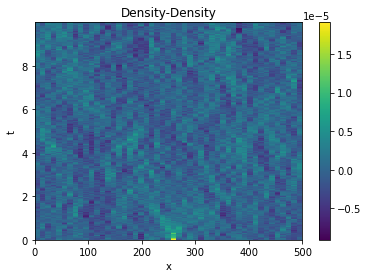

<ipython-input-11-37fb94fc5230>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1 = plt.pcolormesh(X, T, C1.T)


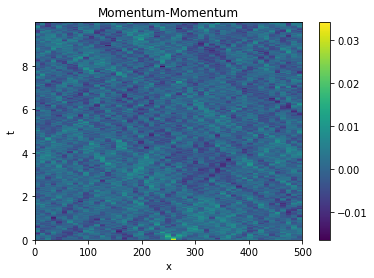

<ipython-input-11-37fb94fc5230>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1 = plt.pcolormesh(X, T, C2.T)


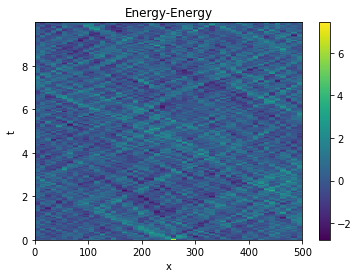

<ipython-input-11-37fb94fc5230>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1 = plt.pcolormesh(X, T, C3.T)


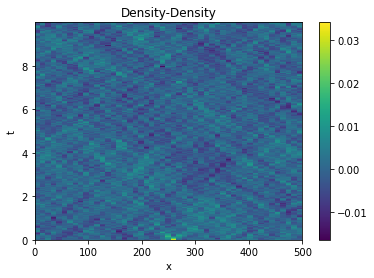

<ipython-input-11-37fb94fc5230>:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1 = plt.pcolormesh(X, T, C4.T)


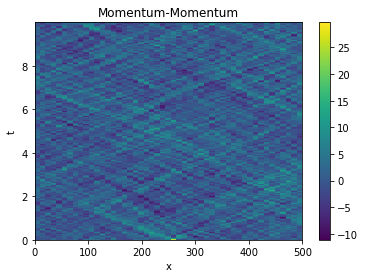

<ipython-input-11-37fb94fc5230>:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1 = plt.pcolormesh(X, T, C5.T)


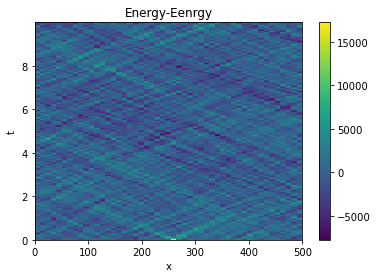

<ipython-input-11-37fb94fc5230>:48: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm2 = plt.pcolormesh(X, T,np.abs(C0FT).T, vmin = 0, vmax = 20)


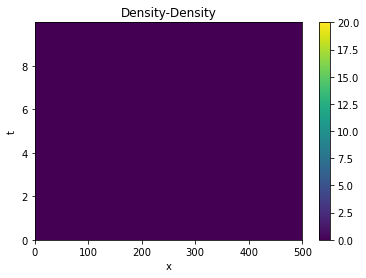

<ipython-input-11-37fb94fc5230>:56: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm2 = plt.pcolormesh(X, T,np.abs(C0FT).T, vmin = 0, vmax = 20)


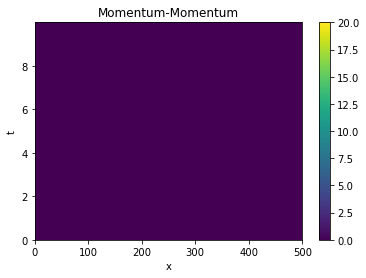

<ipython-input-11-37fb94fc5230>:64: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm2 = plt.pcolormesh(X, T,np.abs(C0FT).T, vmin = 0, vmax = 20)


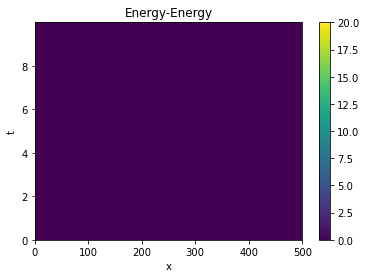

<ipython-input-11-37fb94fc5230>:72: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm2 = plt.pcolormesh(X, T,np.abs(C0FT).T, vmin = 0, vmax = 20)


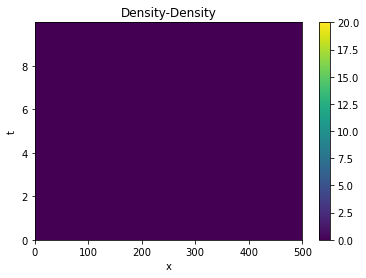

<ipython-input-11-37fb94fc5230>:80: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm2 = plt.pcolormesh(X, T,np.abs(C0FT).T, vmin = 0, vmax = 20)


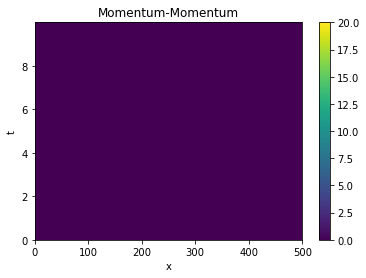

<ipython-input-11-37fb94fc5230>:88: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm2 = plt.pcolormesh(X, T,np.abs(C0FT).T, vmin = 0, vmax = 20)


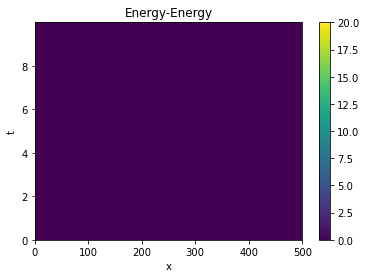

In [11]:
T, X = np.meshgrid(t[:maxtime], x_grid)

pcm1 = plt.pcolormesh(X, T, C0.T)
plt.title('Density-Density')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()
plt.show()

pcm1 = plt.pcolormesh(X, T, C1.T)
plt.title('Momentum-Momentum')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()
plt.show()

pcm1 = plt.pcolormesh(X, T, C2.T)
plt.title('Energy-Energy')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()
plt.show()

pcm1 = plt.pcolormesh(X, T, C3.T)
plt.title('Density-Density')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()
plt.show()

pcm1 = plt.pcolormesh(X, T, C4.T)
plt.title('Momentum-Momentum')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()
plt.show()

pcm1 = plt.pcolormesh(X, T, C5.T)
plt.title('Energy-Eenrgy')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()
plt.show()

T, X = np.meshgrid(t[:maxtime], x_grid)

C0FT = fft2(C0)
pcm2 = plt.pcolormesh(X, T,np.abs(C0FT).T, vmin = 0, vmax = 20)
plt.title('Density-Density')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()
plt.show()

C1FT = fft2(C1)
pcm2 = plt.pcolormesh(X, T,np.abs(C0FT).T, vmin = 0, vmax = 20)
plt.title('Momentum-Momentum')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()
plt.show()

C2FT = fft2(C2)
pcm2 = plt.pcolormesh(X, T,np.abs(C0FT).T, vmin = 0, vmax = 20)
plt.title('Energy-Energy')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()
plt.show()

C3FT = fft2(C3)
pcm2 = plt.pcolormesh(X, T,np.abs(C0FT).T, vmin = 0, vmax = 20)
plt.title('Density-Density')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()
plt.show()

C4FT = fft2(C4)
pcm2 = plt.pcolormesh(X, T,np.abs(C0FT).T, vmin = 0, vmax = 20)
plt.title('Momentum-Momentum')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()
plt.show()

C5FT = fft2(C5)
pcm2 = plt.pcolormesh(X, T,np.abs(C0FT).T, vmin = 0, vmax = 20)
plt.title('Energy-Energy')
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()
plt.show()